# Lab 01 - Set Cover Problem

In [10]:
# imports section
from itertools import accumulate
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from collections import deque
from concurrent.futures import ThreadPoolExecutor, as_completed

### Function Descriptions

- **`valid(solution, SETS)`**: This function checks if a given solution covers all elements in the universe. It returns `True` if all elements are covered, and `False` otherwise.

- **`cost(solution, COSTS)`**: This function calculates the total cost of a given solution by summing the costs associated with the selected sets. It returns the total cost.

- **`multiple_mutation(solution, rng, NUM_SETS)`**: This function generates a new solution by flipping random bits in the current solution. Each bit has a 1% chance of being flipped, resulting in a mutated solution.

- **`tweak`**: This is an alias for the `multiple_mutation` function, allowing it to be used interchangeably.

- **`fitness(solution, SETS, COSTS)`**: This function evaluates a given solution and returns a tuple containing two values: its validity (whether it covers the universe) and its negative cost. The negative cost is used for optimization purposes, as lower costs are preferred.


In [46]:
# function that given a solution returns if it is valid or not (if it covers all the universe or not)
def valid(solution, SETS):
    return np.all(np.logical_or.reduce(SETS[solution]))

# function that given a solution returns its cost
def cost(solution, COSTS):
    return COSTS[solution].sum()

# define the tweak function that creates a new solution from the current one by flipping a random bit
def multiple_mutation(solution: np.ndarray, rng, NUM_SETS) -> np.ndarray:
    mask = rng.random(NUM_SETS) < 0.01  # 1% chance of being true

    # XOR the mask with the solution to flip the bits:
    new_solution = np.logical_xor(solution, mask)
    return new_solution

# define the tweak function
tweak = multiple_mutation

# define the fitness function that, given a solution, returns a tuple with its validity and -cost
def fitness(solution, SETS, COSTS):
    return (valid(solution, SETS), -cost(solution, COSTS))

#### The `run_tabu_search` function implements the Tabu Search optimization algorithm to find an optimal solution based on a given instance of parameters: `UNIVERSE_SIZE`, `NUM_SETS`, and `DENSITY`.

- **Set Generation**: It creates a boolean matrix `SETS`, representing sets of elements, influenced by the specified density.
- **Cost Calculation**: The function calculates the cost for each set, raising the sum of elements to the power of 1.1.
- **Optimization Process**: Over a maximum of 1000 iterations, it generates neighboring solutions, evaluates their fitness, and updates the current solution if a better one is found, using a tabu list to avoid revisiting solutions.
- **Output**: The function prints the best fitness achieved and the number of steps taken to find it, and it visualizes the cost history through a plot.



In [50]:
def run_tabu_search(instance):
    UNIVERSE_SIZE, NUM_SETS, DENSITY = instance
    print(f"UNIVERSE_SIZE: {UNIVERSE_SIZE}, NUM_SETS: {NUM_SETS}, DENSITY: {DENSITY}")

    # total number of steps to run the algorithm
    totSteps = 1000

    # define the sets
    SETS = np.random.binomial(1, DENSITY, size=(NUM_SETS, UNIVERSE_SIZE)).astype(bool)

    for s in range(UNIVERSE_SIZE):
        if not np.any(SETS[:, s]):
            SETS[np.random.randint(NUM_SETS), s] = True

    # compute the costs by summing the number of elements in each set and raising to the power of 1.1
    COSTS = np.power(SETS.sum(axis=1), 1.1)   # or np.power

    # initialize the random number generator
    rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

    ### TABU SEARCH ###
    # define the tabu list as a double-ended queue with a maximum size in order to keep automatically only
    # the last tabu_size solutions
    tabu_list = deque(maxlen=50)

    # initialize a random solution given a percentage of being true
    initial_solution = np.full(NUM_SETS, True)

    # compute the fitness of the initial solution
    current_solution = initial_solution
    current_fitness = fitness(current_solution, SETS, COSTS)

    # initialize the best solution and fitness
    best_solution = np.copy(current_solution)
    best_fitness = current_fitness

    # number of iterations to find the best solution
    best_steps = 0

    # initialize the history of the costs
    history = [current_fitness[1]]

    print(f"Initial solution fitness: {current_fitness[1]}")

    # run the algorithm totSteps times
    for steps in range(totSteps):
        neighborhood = []   # list of neighbor solutions
        
        for _ in range(20):  # generate 20 neighbors
            neighbor = tweak(current_solution, rng, NUM_SETS)  # generate a neighbor solution by tweaking the current one
            if not any(np.array_equal(neighbor, sol) for sol in tabu_list):  # check if the neighbor is NOT in the tabu list    
                neighborhood.append(neighbor)

        # if there is no neighbor
        if not neighborhood:
            continue
            
        # find the best neighbor
        best_neighbor = max(neighborhood, key=lambda x: fitness(x, SETS, COSTS))

        best_neighbor_fitness = fitness(best_neighbor, SETS, COSTS)

        # update the tabu list
        tabu_list.append(np.copy(best_neighbor))

        # update the current solution and fitness
        current_solution = best_neighbor
        current_fitness = best_neighbor_fitness
        
        if current_fitness > best_fitness:
            best_solution = np.copy(current_solution)
            best_fitness = current_fitness
            best_steps = steps
        
        history.append(current_fitness[1])

    # print the best solution and fitness and plot the history of the costs
    print(f"Best solution fitness: {best_fitness[1]}")
    print(f"Best solution found after {best_steps} steps")

    plt.figure(figsize = (7, 4))
    plt.plot(
        range(len(history)),
        list(accumulate(history, max)),
        color = "red"
    )

    plt.scatter(range(len(history)), history, marker = ".")
    plt.show()

#### To reduce the computational time required to execute the algorithm on a universe of 100,000 elements, a counter has been introduced that starts counting after the first best solution is found and automatically stops the execution of the loop after 100 additional steps (while still increasing the solution).

In [54]:
def run_tabu_search_counter(instance):
    UNIVERSE_SIZE, NUM_SETS, DENSITY = instance
    print(f"UNIVERSE_SIZE: {UNIVERSE_SIZE}, NUM_SETS: {NUM_SETS}, DENSITY: {DENSITY}")

    # total number of steps to run the algorithm
    totSteps = 1000

    # Counter that starts to count after I find a solution better than the previous one: if 
    # the counter reaches the value 50 without finding a better solution, the loop breaks.
    # I used it to avoid computational problems with the instances with 100_000 elements.
    counter = 0

    # define the sets
    SETS = np.random.binomial(1, DENSITY, size=(NUM_SETS, UNIVERSE_SIZE)).astype(bool)

    for s in range(UNIVERSE_SIZE):
        if not np.any(SETS[:, s]):
            SETS[np.random.randint(NUM_SETS), s] = True

    # compute the costs by summing the number of elements in each set and raising to the power of 1.1
    COSTS = np.power(SETS.sum(axis=1), 1.1)   # or np.power

    # initialize the random number generator
    rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

    ### TABU SEARCH ###
    # define the tabu list as a double-ended queue with a maximum size in order to keep automatically only
    # the last tabu_size solutions
    tabu_list = deque(maxlen=50)

    # initialize a random solution given a percentage of being true
    initial_solution = np.full(NUM_SETS, True)

    # compute the fitness of the initial solution
    current_solution = initial_solution
    current_fitness = fitness(current_solution, SETS, COSTS)

    # initialize the best solution and fitness
    best_solution = np.copy(current_solution)
    best_fitness = current_fitness

    # number of iterations to find the best solution
    best_steps = 0

    # initialize the history of the costs
    history = [current_fitness[1]]

    print(f"Initial solution fitness: {current_fitness[1]}")

    # run the algorithm totSteps times
    for steps in range(totSteps):
        neighborhood = []   # list of neighbor solutions
        
        for _ in range(20):  # generate 20 neighbors
            neighbor = tweak(current_solution, rng, NUM_SETS)  # generate a neighbor solution by tweaking the current one
            if not any(np.array_equal(neighbor, sol) for sol in tabu_list):  # check if the neighbor is NOT in the tabu list    
                neighborhood.append(neighbor)

        # if there is no neighbor
        if not neighborhood:
            continue
            
        # find the best neighbor
        best_neighbor = max(neighborhood, key=lambda x: fitness(x, SETS, COSTS))

        best_neighbor_fitness = fitness(best_neighbor, SETS, COSTS)

        # update the tabu list
        tabu_list.append(np.copy(best_neighbor))

        # update the current solution and fitness
        current_solution = best_neighbor
        current_fitness = best_neighbor_fitness
        
        if current_fitness > best_fitness:
            best_solution = np.copy(current_solution)
            best_fitness = current_fitness
            best_steps = steps
            if(counter == 0): counter += 1  # if it's the first time I find a better solution, increase counter by 1

        # if counter is > 0 it means that we already found a best solution, so it's 
        # increased at every iteration
        if(counter > 0): counter += 1
        
        history.append(current_fitness[1])

        # break the loop if the counter reaches 100
        if counter == 100:
            break

    # print the best solution and fitness and plot the history of the costs
    print(f"Best solution fitness: {best_fitness[1]}")
    print(f"Best solution found after {best_steps} steps")

    plt.figure(figsize = (7, 4))
    plt.plot(
        range(len(history)),
        list(accumulate(history, max)),
        color = "red"
    )

    plt.scatter(range(len(history)), history, marker = ".")
    plt.show()

UNIVERSE_SIZE: 100, NUM_SETS: 10, DENSITY: 0.2
Initial solution fitness: -261.43711990984497
Best solution fitness: -261.43711990984497
Best solution found after 0 steps


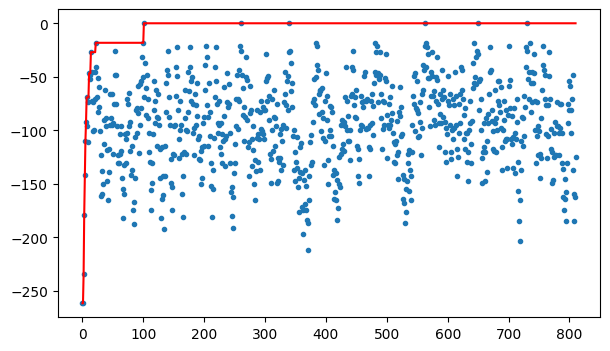

UNIVERSE_SIZE: 1000, NUM_SETS: 100, DENSITY: 0.2
Initial solution fitness: -34182.616109435316
Best solution fitness: -6474.899988036715
Best solution found after 221 steps


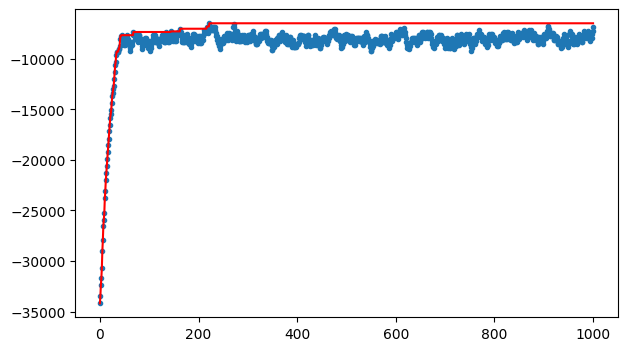

UNIVERSE_SIZE: 10000, NUM_SETS: 1000, DENSITY: 0.2
Initial solution fitness: -4275456.167098381
Best solution fitness: -826980.8848266075
Best solution found after 518 steps


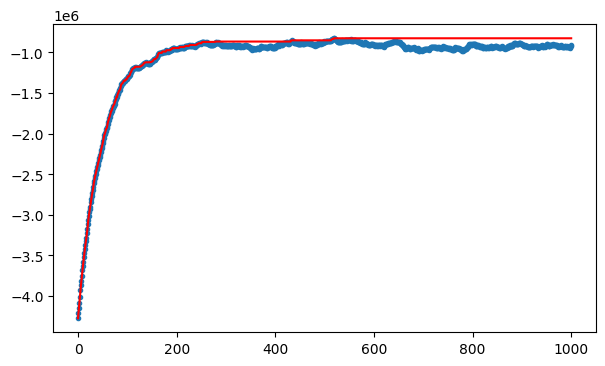

In [51]:
instances1 = [(100, 10, 0.2), (1000, 100, 0.2), (10_000, 1000, 0.2)]

for instance in instances1:
    run_tabu_search(instance)

In [55]:
instances2 = [(100_000, 10_000, 0.1), (100_000, 10_000, 0.2), (100_000, 10_000, 0.3)]

for instance in instances2:
    run_tabu_search_counter(instance)

UNIVERSE_SIZE: 100000, NUM_SETS: 10000, DENSITY: 0.1


KeyboardInterrupt: 